Theory : https://towardsdatascience.com/understanding-random-forest-58381e0602d2

Examples : https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

# Probability of surges

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import geopandas as gpd
from shapely.geometry import Polygon

import matplotlib.pyplot as plt

from sklearn.utils import resample

### Set random seed to ensure reproducible runs

In [2]:
RSEED = 50

### Importing data and data cleaning

In [3]:
df_main = pd.read_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced/df_main.csv', index_col=['rgiid', 'x', 'y'])
df_main

Unnamed: 0  Surge   Area  Slope  \
rgiid          x             y                                               
RGI60-07.00004 524657.521964 8.539931e+06         206      0  1.044   13.8   
               524681.113471 8.539955e+06         207      0  1.044   13.8   
               524704.704977 8.539980e+06         208      0  1.044   13.8   
               524728.296484 8.540004e+06         209      0  1.044   13.8   
               524751.887990 8.540028e+06         210      0  1.044   13.8   
...                                               ...    ...    ...    ...   
RGI60-07.01567 534269.488654 8.675206e+06      130984      3  5.350   11.7   
               534310.362510 8.675249e+06      130985      3  5.350   11.7   
               534309.250485 8.675291e+06      130986      3  5.350   11.7   
               534308.138459 8.675333e+06      130987      3  5.350   11.7   
               534307.026431 8.675375e+06      130988      3  5.350   11.7   

                                           TermType          Name        bed  \
rgiid          x             y                                                 
RGI60-07.00004 524657.521964 8.539931e+06         0           NaN  889.68555   
               524681.113471 8.539955e+06         0           NaN  882.06460   
               524704.704977 8.539980e+06         0           NaN  882.06460   
               524728.296484 8.540004e+06         0           NaN  882.06460   
               524751.887990 8.540028e+06         0           NaN  881.31860   
...                                             ...           ...        ...   
RGI60-07.01567 534269.488654 8.675206e+06         0  Moeysalbreen  237.64468   
               534310.362510 8.675249e+06         0  Moeysalbreen  233.07228   
               534309.250485 8.675291e+06         0  Moeysalbreen  233.07228   
               534308.138459 8.675333e+06         0  Moeysalbreen  233.18828   
               534307.026431 8.675375e+06         0  Moeysalbreen  233.18828   

                                           thickness  surface_elevation  \
rgiid          x             y                                            
RGI60-07.00004 524657.521964 8.539931e+06  25.314478          915.00000   
               524681.113471 8.539955e+06  30.935455          913.00000   
               524704.704977 8.539980e+06  30.935455          913.00000   
               524728.296484 8.540004e+06  30.935455          913.00000   
               524751.887990 8.540028e+06  34.681380          916.00000   
...                                              ...                ...   
RGI60-07.01567 534269.488654 8.675206e+06  50.380424          288.02512   
               534310.362510 8.675249e+06  46.717087          279.78937   
               534309.250485 8.675291e+06  46.717087          279.78937   
               534308.138459 8.675333e+06  47.159560          280.34784   
               534307.026431 8.675375e+06  47.159560          280.34784   

                                                  ELA      beta       cmb  \
rgiid          x             y                                              
RGI60-07.00004 524657.521964 8.539931e+06  432.103017  0.005069  1.392706   
               524681.113471 8.539955e+06  432.421537  0.005068  1.391001   
               524704.704977 8.539980e+06  432.740057  0.005068  1.389296   
               524728.296484 8.540004e+06  433.058576  0.005067  1.387591   
               524751.887990 8.540028e+06  433.377096  0.005067  1.385886   
...                                               ...       ...       ...   
RGI60-07.01567 534269.488654 8.675206e+06  627.625366  0.004612 -1.412920   
               534310.362510 8.675249e+06  627.625366  0.004614 -1.423469   
               534309.250485 8.675291e+06  627.625366  0.004618 -1.395654   
               534308.138459 8.675333e+06  627.625366  0.004620 -1.382369   
               534307.026431 8.675375e+06  627.625366  0.004621 -1.369084   

         

In [4]:
df_main['SMB_calc'] = df_main['beta']*(df_main['surface_elevation']-df_main['ELA'])
df_main

Unnamed: 0  Surge   Area  Slope  \
rgiid          x             y                                               
RGI60-07.00004 524657.521964 8.539931e+06         206      0  1.044   13.8   
               524681.113471 8.539955e+06         207      0  1.044   13.8   
               524704.704977 8.539980e+06         208      0  1.044   13.8   
               524728.296484 8.540004e+06         209      0  1.044   13.8   
               524751.887990 8.540028e+06         210      0  1.044   13.8   
...                                               ...    ...    ...    ...   
RGI60-07.01567 534269.488654 8.675206e+06      130984      3  5.350   11.7   
               534310.362510 8.675249e+06      130985      3  5.350   11.7   
               534309.250485 8.675291e+06      130986      3  5.350   11.7   
               534308.138459 8.675333e+06      130987      3  5.350   11.7   
               534307.026431 8.675375e+06      130988      3  5.350   11.7   

                                           TermType          Name        bed  \
rgiid          x             y                                                 
RGI60-07.00004 524657.521964 8.539931e+06         0           NaN  889.68555   
               524681.113471 8.539955e+06         0           NaN  882.06460   
               524704.704977 8.539980e+06         0           NaN  882.06460   
               524728.296484 8.540004e+06         0           NaN  882.06460   
               524751.887990 8.540028e+06         0           NaN  881.31860   
...                                             ...           ...        ...   
RGI60-07.01567 534269.488654 8.675206e+06         0  Moeysalbreen  237.64468   
               534310.362510 8.675249e+06         0  Moeysalbreen  233.07228   
               534309.250485 8.675291e+06         0  Moeysalbreen  233.07228   
               534308.138459 8.675333e+06         0  Moeysalbreen  233.18828   
               534307.026431 8.675375e+06         0  Moeysalbreen  233.18828   

                                           thickness  surface_elevation  \
rgiid          x             y                                            
RGI60-07.00004 524657.521964 8.539931e+06  25.314478          915.00000   
               524681.113471 8.539955e+06  30.935455          913.00000   
               524704.704977 8.539980e+06  30.935455          913.00000   
               524728.296484 8.540004e+06  30.935455          913.00000   
               524751.887990 8.540028e+06  34.681380          916.00000   
...                                              ...                ...   
RGI60-07.01567 534269.488654 8.675206e+06  50.380424          288.02512   
               534310.362510 8.675249e+06  46.717087          279.78937   
               534309.250485 8.675291e+06  46.717087          279.78937   
               534308.138459 8.675333e+06  47.159560          280.34784   
               534307.026431 8.675375e+06  47.159560          280.34784   

                                                  ELA      beta       cmb  \
rgiid          x             y                                              
RGI60-07.00004 524657.521964 8.539931e+06  432.103017  0.005069  1.392706   
               524681.113471 8.539955e+06  432.421537  0.005068  1.391001   
               524704.704977 8.539980e+06  432.740057  0.005068  1.389296   
               524728.296484 8.540004e+06  433.058576  0.005067  1.387591   
               524751.887990 8.540028e+06  433.377096  0.005067  1.385886   
...                                               ...       ...       ...   
RGI60-07.01567 534269.488654 8.675206e+06  627.625366  0.004612 -1.412920   
               534310.362510 8.675249e+06  627.625366  0.004614 -1.423469   
               534309.250485 8.675291e+06  627.625366  0.004618 -1.395654   
               534308.138459 8.675333e+06  627.625366  0.004620 -1.382369   
               534307.026431 8.675375e+06  627.625366  0.004621 -1.369084   

         

In [5]:
df_main['WH'] = df_main['width_centerline'] / df_main['thickness']
df_main['WHsin'] = df_main['thickness']*df_main['width_centerline']*np.sin(df_main['Slope'])
df_main['dummy'] = np.random.rand(df_main.shape[0])

In [6]:
df = df_main.drop(df_main[df_main['Surge']==9].index)
df = df.drop(df_main[df_main['Surge']==1].index)
# df = df_main.drop(df_main[df_main['Surge']==2].index)
df = df.drop(columns = ['Unnamed: 0', 'ELA', 'beta', 'Name', 'Area', 'cmb'])
df.dropna(how='any', inplace=True)

In [7]:
df.groupby('Surge').count()

,Slope,TermType,bed,thickness,surface_elevation,width_centerline,Runoff,SMB_calc,WH,WHsin,dummy
Surge,,,,,,,,,,,
0,68675,68675,68675,68675,68675,68675,68675,68675,68675,68675,68675
2,4249,4249,4249,4249,4249,4249,4249,4249,4249,4249,4249
3,10897,10897,10897,10897,10897,10897,10897,10897,10897,10897,10897


In [8]:
df['Surge'] = df['Surge'].replace({3: 1, 2:1})
df = df.loc[df['Surge'].isin([0, 1])].copy()
df = df.rename(columns = {'Surge': 'label'})
df['label'].value_counts()

0    68675
1    15146
Name: label, dtype: int64

In [9]:
df[df['label']==1].shape[0]

15146

In [10]:
df.shape

(83821, 12)

### Resampled

In [11]:
# Separate majority and minority classes
df_majority = df[df['label']==0]
df_minority = df[df['label']==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df[df['label']==1].shape[0],     # to match minority class
                                 random_state=RSEED) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled['label'].value_counts()
df = df_downsampled

In [12]:
df_downsampled.shape

(30292, 12)

In [13]:
# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

In [14]:
train_labels.sum()/train_labels.shape[0]

0.5

In [15]:
test_labels.sum()/test_labels.shape[0]

0.5

In [16]:
# Features for feature importances
features = list(train.columns)
features

['Slope',
 'TermType',
 'bed',
 'thickness',
 'surface_elevation',
 'width_centerline',
 'Runoff',
 'SMB_calc',
 'WH',
 'WHsin',
 'dummy']

In [17]:
train.head()

,,,Slope,TermType,bed,thickness,surface_elevation,width_centerline,Runoff,SMB_calc,WH,WHsin,dummy
rgiid,x,y,,,,,,,,,,,
RGI60-07.00515,441975.150359,8.727522e+06,19.5,0,264.174900,38.879795,303.0547,576.297132,2.549741,-1.518291,14.822535,13567.916665,0.278298
RGI60-07.00873,548147.700372,8.772440e+06,7.4,0,1034.511800,81.036380,1115.5482,4308.036475,0.253687,0.200014,53.161759,313745.899081,0.547492
RGI60-07.00859,530846.114530,8.837916e+06,9.1,1,579.684600,214.568920,794.2535,7218.261007,0.504620,0.259796,33.640758,494224.160475,0.903795
RGI60-07.00315,578764.810581,8.620960e+06,9.4,1,-28.271210,97.271210,69.0000,2263.341551,2.532262,-1.377222,23.268360,5454.507405,0.195868
RGI60-07.00233,514508.764759,8.598699e+06,10.7,0,-33.664413,150.664410,117.0000,864.509164,3.193687,-3.300643,5.737979,-124602.440895,0.446921


In [18]:
train_labels.shape

(21204,)

In [19]:
test.head()

,,,Slope,TermType,bed,thickness,surface_elevation,width_centerline,Runoff,SMB_calc,WH,WHsin,dummy
rgiid,x,y,,,,,,,,,,,
RGI60-07.00465,478371.303131,8.716493e+06,8.1,1,46.214294,221.83762,268.05190,5613.527053,2.654832,-1.401845,25.304667,1.207796e+06,0.521783
RGI60-07.01090,489770.321036,8.649560e+06,10.6,0,147.998780,71.05932,219.05810,645.227888,1.370421,-1.918945,9.080130,-4.230875e+04,0.745462
RGI60-07.00406,557921.341535,8.663047e+06,12.2,0,184.157470,48.18905,232.34653,619.202874,2.521803,-1.821770,12.849452,-1.068913e+04,0.003783
RGI60-07.00862,541092.973415,8.860543e+06,9.7,0,165.962950,90.94358,256.90652,276.764792,1.145731,-0.664016,3.043258,-6.840210e+03,0.053804
RGI60-07.00169,530699.535153,8.626463e+06,14.4,0,551.148100,41.85196,593.00000,1038.449988,1.399670,0.206295,24.812458,4.196861e+04,0.682349


# Gradient boosting

In [20]:
import xgboost
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

In [21]:
df_main.columns

Index(['Unnamed: 0', 'Surge', 'Area', 'Slope', 'TermType', 'Name', 'bed',
       'thickness', 'surface_elevation', 'ELA', 'beta', 'cmb',
       'width_centerline', 'Runoff', 'SMB_calc', 'WH', 'WHsin', 'dummy'],
      dtype='object')

In [22]:
df_main.dropna().shape

(73514, 18)

In [23]:
df_main.dropna(inplace=True)

In [24]:
test_full_labels = df_main['Surge']
# test_full = df_main.dropna(inplace=True)
test_full = df_main.drop(columns=['Unnamed: 0', 'Surge', 'Area', 'Name', 'ELA', 'beta', 'cmb'])
test_full

Slope  TermType        bed  \
rgiid          x             y                                          
RGI60-07.00006 537467.580455 8.536842e+06   12.6         1  591.49146   
               537404.091767 8.536902e+06   12.6         1  591.49146   
               537340.603079 8.536963e+06   12.6         1  565.43870   
               537277.114391 8.537023e+06   12.6         1  547.37540   
               537213.625703 8.537084e+06   12.6         1  514.92160   
...                                          ...       ...        ...   
RGI60-07.01567 534269.488654 8.675206e+06   11.7         0  237.64468   
               534310.362510 8.675249e+06   11.7         0  233.07228   
               534309.250485 8.675291e+06   11.7         0  233.07228   
               534308.138459 8.675333e+06   11.7         0  233.18828   
               534307.026431 8.675375e+06   11.7         0  233.18828   

                                           thickness  surface_elevation  \
rgiid          x             y                                            
RGI60-07.00006 537467.580455 8.536842e+06  24.508570          616.00000   
               537404.091767 8.536902e+06  24.508570          616.00000   
               537340.603079 8.536963e+06  23.561293          589.00000   
               537277.114391 8.537023e+06  24.624578          572.00000   
               537213.625703 8.537084e+06  27.078419          542.00000   
...                                              ...                ...   
RGI60-07.01567 534269.488654 8.675206e+06  50.380424          288.02512   
               534310.362510 8.675249e+06  46.717087          279.78937   
               534309.250485 8.675291e+06  46.717087          279.78937   
               534308.138459 8.675333e+06  47.159560          280.34784   
               534307.026431 8.675375e+06  47.159560          280.34784   

                                           width_centerline    Runoff  \
rgiid          x             y                                          
RGI60-07.00006 537467.580455 8.536842e+06       1098.398114  1.653396   
               537404.091767 8.536902e+06       1141.233362  1.586801   
               537340.603079 8.536963e+06       1144.919151  1.520206   
               537277.114391 8.537023e+06       1105.995748  1.453610   
               537213.625703 8.537084e+06       1069.477866  1.434204   
...                                                     ...       ...   
RGI60-07.01567 534269.488654 8.675206e+06        278.553621  2.123592   
               534310.362510 8.675249e+06        256.755923  2.127417   
               534309.250485 8.675291e+06        238.477978  2.076787   
               534308.138459 8.675333e+06        226.342325  2.005969   
               534307.026431 8.675375e+06        215.631320  1.935151   

                                           SMB_calc         WH         WHsin  \
rgiid          x             y                                                 
RGI60-07.00006 537467.580455 8.536842e+06  0.752798  44.816899    905.138048   
               537404.091767 8.536902e+06  0.753056  46.564665    940.436555   
               537340.603079 8.536963e+06  0.573153  48.593222    907.007776   
               537277.114391 8.537023e+06  0.459876  44.914303    915.712884   
               537213.625703 8.537084e+06  0.259794  39.495580    973.715707   
...                                             ...        ...           ...   
RGI60-07.01567 534269.488654 8.675206e+06 -1.566323   5.529005 -10693.410549   
               534310.362510 8.675249e+06 -1.604864   5.495975  -9139.908345   
               534309.250485 8.675291e+06 -1.606379   5.104727  -8489.256385   
               534308.138459 8.675333e+06 -1.604294   4.799500  -8133.568561   
               534307.026431 8.675375e+06 -1.604788   4.572378  -7748.670623   

                                              dummy  
rgiid          x             y                       
RGI60-07.00006 537

In [25]:
dmatrix_train = xgboost.DMatrix(train, label=train_labels)
dmatrix_test = xgboost.DMatrix(test[test.columns], label=test_labels)

In [26]:
test_labels.shape

(9088,)

In [27]:
test_labels.shape

(9088,)

In [28]:
# params = {'objective':'reg:logistic', 'num_boost_round':20000, 'max_depth':1, 'scale_pos_weight':0.5}
params = {'objective':'reg:logistic', 'max_depth':1, 'scale_pos_weight':0.5}

xgb = xgboost.XGBClassifier(**params)
xgb.fit(train, train_labels)
# xgb = xgboost.train(params, dmatrix_train, num_boost_round=20000)

/usr/local/lib64/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=0.5, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [62]:
np.arange(len(test_full.columns))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [56]:
features = [0, 2, (0, 2)]
features

[0, 2, (0, 2)]

In [80]:
from sklearn.inspection import partial_dependence

pdps = []
axes = []

for i in np.arange(len(test_full.columns)):    
    pdp = partial_dependence(xgb, train, [i], kind='both')
    pdps.append(pdp)
#     axes.append(ax)

Text(0.5, 1.0, 'Partial dependence of the slope')

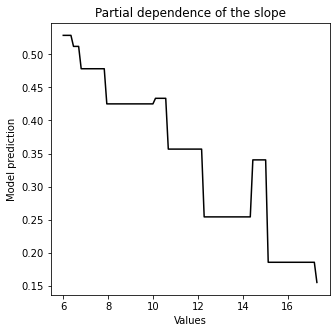

In [97]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(pdps[0]['values'][0], pdps[0].average[0], 'k')
ax.set_ylabel('Model prediction')
ax.set_xlabel('Values')
ax.set_title('Partial dependence of the slope')

Text(0.5, 1.0, 'Partial dependence of the terminus type')

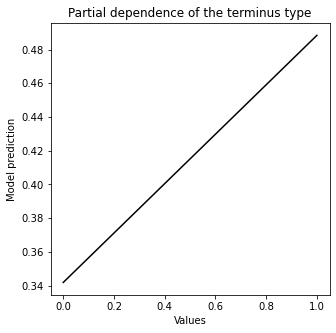

In [98]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(pdps[1]['values'][0], pdps[1].average[0], 'k')
ax.set_ylabel('Model prediction')
ax.set_xlabel('Values')
ax.set_title('Partial dependence of the terminus type')

Text(0.5, 1.0, 'Partial dependence of the bed elevation')

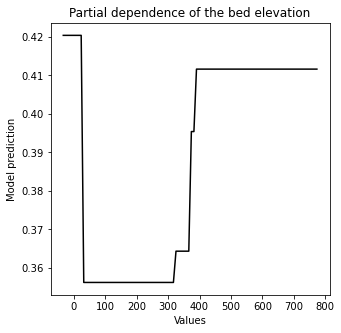

In [99]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(pdps[2]['values'][0], pdps[2].average[0], 'k')
ax.set_ylabel('Model prediction')
ax.set_xlabel('Values')
ax.set_title('Partial dependence of the bed elevation')

In [100]:
test_full.columns

Index(['Slope', 'TermType', 'bed', 'thickness', 'surface_elevation',
       'width_centerline', 'Runoff', 'SMB_calc', 'WH', 'WHsin', 'dummy'],
      dtype='object')

Text(0.5, 1.0, 'Partial dependence of the thickness')

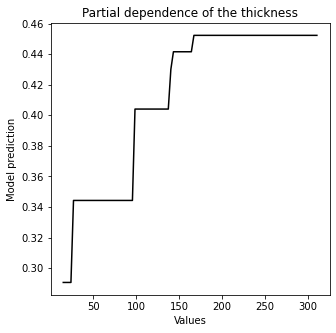

In [101]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(pdps[3]['values'][0], pdps[3].average[0], 'k')
ax.set_ylabel('Model prediction')
ax.set_xlabel('Values')
ax.set_title('Partial dependence of the thickness')

Text(0.5, 1.0, 'Partial dependence of the surface elevation')

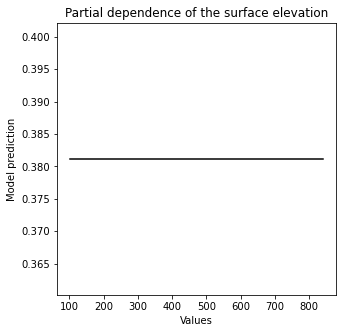

In [102]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(pdps[4]['values'][0], pdps[4].average[0], 'k')
ax.set_ylabel('Model prediction')
ax.set_xlabel('Values')
ax.set_title('Partial dependence of the surface elevation')

Text(0.5, 1.0, 'Partial dependence of the width')

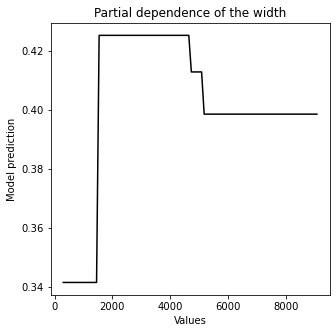

In [103]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(pdps[5]['values'][0], pdps[5].average[0], 'k')
ax.set_ylabel('Model prediction')
ax.set_xlabel('Values')
ax.set_title('Partial dependence of the width')

Text(0.5, 1.0, 'Partial dependence of the runoff')

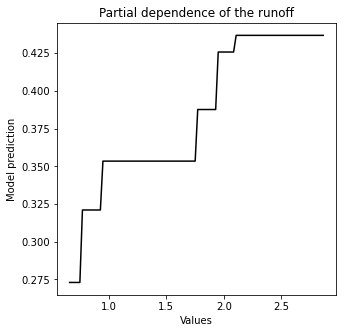

In [104]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(pdps[6]['values'][0], pdps[6].average[0], 'k')
ax.set_ylabel('Model prediction')
ax.set_xlabel('Values')
ax.set_title('Partial dependence of the runoff')

Text(0.5, 1.0, 'Partial dependence of the SMB')

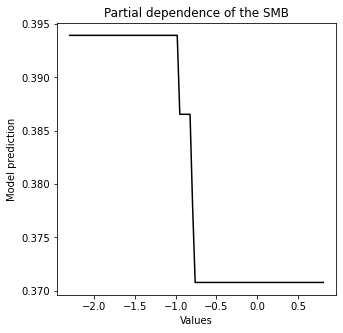

In [106]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(pdps[7]['values'][0], pdps[7].average[0], 'k')
ax.set_ylabel('Model prediction')
ax.set_xlabel('Values')
ax.set_title('Partial dependence of the SMB')

Text(0.5, 1.0, 'Partial dependence of the WH')

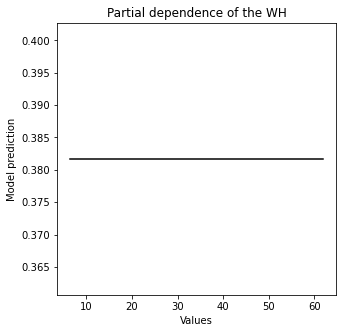

In [107]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(pdps[8]['values'][0], pdps[8].average[0], 'k')
ax.set_ylabel('Model prediction')
ax.set_xlabel('Values')
ax.set_title('Partial dependence of the WH')

Text(0.5, 1.0, 'Partial dependence of the WHsin(slope)')

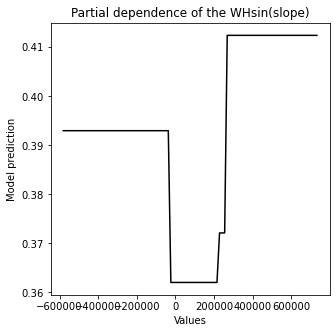

In [108]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(pdps[9]['values'][0], pdps[9].average[0], 'k')
ax.set_ylabel('Model prediction')
ax.set_xlabel('Values')
ax.set_title('Partial dependence of the WHsin(slope)')

In [250]:
value_per={}
for j in np.arange(len(test_full.columns)):
    for i in np.arange(len(pdps[j]['values'][0])):
#         value_per[str(test_full.columns[j])] = pdps[j]['values'][0]*100/pdps[j]['values'][0].max()
          value_per[str(test_full.columns[j])] = (pdps[j]['values'][0]-pdps[j]['values'][0].min())/(pdps[j]['values'][0].max()-pdps[j]['values'][0].min())*100

value_per['Slope']

array([  0.        ,   1.01010101,   2.02020202,   3.03030303,
         4.04040404,   5.05050505,   6.06060606,   7.07070707,
         8.08080808,   9.09090909,  10.1010101 ,  11.11111111,
        12.12121212,  13.13131313,  14.14141414,  15.15151515,
        16.16161616,  17.17171717,  18.18181818,  19.19191919,
        20.2020202 ,  21.21212121,  22.22222222,  23.23232323,
        24.24242424,  25.25252525,  26.26262626,  27.27272727,
        28.28282828,  29.29292929,  30.3030303 ,  31.31313131,
        32.32323232,  33.33333333,  34.34343434,  35.35353535,
        36.36363636,  37.37373737,  38.38383838,  39.39393939,
        40.4040404 ,  41.41414141,  42.42424242,  43.43434343,
        44.44444444,  45.45454545,  46.46464646,  47.47474747,
        48.48484848,  49.49494949,  50.50505051,  51.51515152,
        52.52525253,  53.53535354,  54.54545455,  55.55555556,
        56.56565657,  57.57575758,  58.58585859,  59.5959596 ,
        60.60606061,  61.61616162,  62.62626263,  63.63

In [251]:
for name in value_per.keys():
    print(value_per[name])

[  0.           1.01010101   2.02020202   3.03030303   4.04040404
   5.05050505   6.06060606   7.07070707   8.08080808   9.09090909
  10.1010101   11.11111111  12.12121212  13.13131313  14.14141414
  15.15151515  16.16161616  17.17171717  18.18181818  19.19191919
  20.2020202   21.21212121  22.22222222  23.23232323  24.24242424
  25.25252525  26.26262626  27.27272727  28.28282828  29.29292929
  30.3030303   31.31313131  32.32323232  33.33333333  34.34343434
  35.35353535  36.36363636  37.37373737  38.38383838  39.39393939
  40.4040404   41.41414141  42.42424242  43.43434343  44.44444444
  45.45454545  46.46464646  47.47474747  48.48484848  49.49494949
  50.50505051  51.51515152  52.52525253  53.53535354  54.54545455
  55.55555556  56.56565657  57.57575758  58.58585859  59.5959596
  60.60606061  61.61616162  62.62626263  63.63636364  64.64646465
  65.65656566  66.66666667  67.67676768  68.68686869  69.6969697
  70.70707071  71.71717172  72.72727273  73.73737374  74.74747475
  75.7575757

In [216]:
test_full.columns

Index(['Slope', 'TermType', 'bed', 'thickness', 'surface_elevation',
       'width_centerline', 'Runoff', 'SMB_calc', 'WH', 'WHsin', 'dummy'],
      dtype='object')

In [219]:
value_per['bed'].shape

(100,)

In [252]:
values = value_per.values()
values_list = list(values)

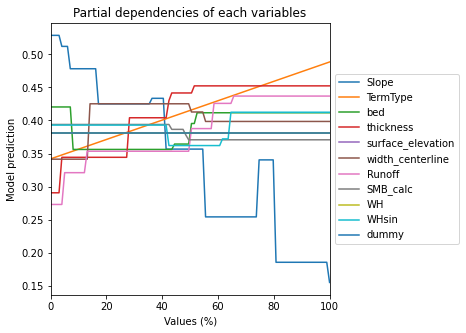

In [253]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_ylabel('Model prediction')
ax.set_xlabel('Values (%)')
ax.set_xlim([0, 100])
ax.set_title('Partial dependencies of each variables')

for i in np.arange(len(test_full.columns)):
        ax.plot(values_list[i], pdps[i].average[0], label=str(test_full.columns[i]))
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
